<div dir=ltr align=center>
<font color=0F5298 size=10>
    Massive Data Mining <br>
<font color=0F5298 size=5>
    Electrical Engineering Department <br>
    Fall 2024 <br>
    Parham Gilani - 400101859 <br>
    Homework 4 - Spark Exercise <br>
    
____

# Import Libraries

In [13]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
import numpy as np
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import hashlib
from collections import deque
from pyspark.sql.functions import col, window, length, dense_rank, desc, unix_timestamp, row_number
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, StringType, TimestampType
import builtins

warnings.filterwarnings('ignore')
spark = SparkSession.builder \
    .appName("MDA2024-HW4") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .config("spark.network.timeout", "7200s") \
    .config("spark.executor.heartbeatInterval", "600s") \
    .config("spark.sql.broadcastTimeout", "7200") \
    .config("spark.sql.shuffle.partitions", "1000") \
    .config("spark.sql.shuffle.partitions", "1") \
    .config("spark.executor.cores", "12") \
    .getOrCreate()

sc=spark.sparkContext

# Question 1:

## A:

In [14]:
# Define the schema for the dataset
schema = StructType([
    StructField("link", StringType(), True),
    StructField("headline", StringType(), True),
    StructField("category", StringType(), True),
    StructField("short_description", StringType(), True),
    StructField("authors", StringType(), True),
    StructField("date", TimestampType(), True)
])

# Load the data as a batch
news_df = spark.read.schema(schema).json("Datasets/news_dataset_MDA2024.json")

# Process the data: Group by category and 20-second interval windows
category_count_df = news_df.withColumn("window", window(col("date"), "20 seconds")) \
    .groupBy("window", "category") \
    .count()

# Display the result
category_count_df.show(truncate=False)


+------------------------------------------+--------------+-----+
|window                                    |category      |count|
+------------------------------------------+--------------+-----+
|{2024-12-29 12:00:00, 2024-12-29 12:00:20}|U.S. NEWS     |5    |
|{2024-12-29 12:00:00, 2024-12-29 12:00:20}|COMEDY        |1    |
|{2024-12-29 12:00:00, 2024-12-29 12:00:20}|PARENTING     |1    |
|{2024-12-29 12:00:00, 2024-12-29 12:00:20}|WORLD NEWS    |2    |
|{2024-12-29 12:00:00, 2024-12-29 12:00:20}|CULTURE & ARTS|1    |
|{2024-12-29 12:00:20, 2024-12-29 12:00:40}|WORLD NEWS    |6    |
|{2024-12-29 12:00:20, 2024-12-29 12:00:40}|TECH          |1    |
|{2024-12-29 12:00:20, 2024-12-29 12:00:40}|U.S. NEWS     |1    |
|{2024-12-29 12:00:20, 2024-12-29 12:00:40}|CULTURE & ARTS|1    |
|{2024-12-29 12:00:20, 2024-12-29 12:00:40}|SPORTS        |1    |
|{2024-12-29 12:00:40, 2024-12-29 12:01:00}|ENTERTAINMENT |2    |
|{2024-12-29 12:00:40, 2024-12-29 12:01:00}|POLITICS      |2    |
|{2024-12-

The schema for the dataset is defined, specifying the fields: `link`, `headline`, `category`, `short_description`, `authors`, and `date`. The dataset is then loaded from a JSON file, with the schema applied. The `window` function is used to group the data into 20-second intervals based on the `date` field. After that, the data is grouped by both the `window` and `category` columns. The `.count()` function is applied to compute the number of entries for each group. The resulting grouped data is stored in `category_count_df`. The output is displayed using `.show()`, showing the window, category, and count values. The data is shown without truncating any column values, providing an overview of how news items are distributed across categories in 20-second intervals.

## B:

In [4]:
# Define the schema for the dataset
schema = StructType([
    StructField("link", StringType(), True),
    StructField("headline", StringType(), True),
    StructField("category", StringType(), True),
    StructField("short_description", StringType(), True),
    StructField("authors", StringType(), True),
    StructField("date", StringType(), True)  # Keeping the date as string initially
])

# Load the dataset
news_df = spark.read.schema(schema).json("Datasets/news_dataset_MDA2024.json")

# Convert 'date' to a timestamp and create a timestamp column
news_df = news_df.withColumn("timestamp", unix_timestamp(col("date"), "yyyy-MM-dd'T'HH:mm:ss").cast("timestamp"))

# Add a new column for the length of the headline
news_df = news_df.withColumn("headline_length", length(col("headline")))

# Define a window for 30-second intervals and group the data
windowed_df = news_df.withColumn("window_start", window(col("timestamp"), "30 seconds").start) \
                     .withColumn("window_end", window(col("timestamp"), "30 seconds").end)

# Define a window spec to rank headlines by length within each 30-second window
window_spec = Window.partitionBy("window_start", "window_end").orderBy(col("headline_length").desc())

# Rank headlines within each window using row_number
ranked_df = windowed_df.withColumn("rank", row_number().over(window_spec)) \
                       .filter(col("rank") <= 3) \
                       .select("window_start", "window_end", "link", "headline", "headline_length")

# Show the top 3 headlines for each 30-second interval
ranked_df.show(truncate=False)


+-------------------+-------------------+--------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------+---------------+
|window_start       |window_end         |link                                                                                                                                  |headline                                                                                             |headline_length|
+-------------------+-------------------+--------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------+---------------+
|2024-12-29 12:00:00|2024-12-29 12:00:30|https://www.huffpost.com/entry/american-airlines-passenger-banned-flight-a

The code processes a news dataset by reading it and defining its schema, which includes columns like `link`, `headline`, `category`, and `date`. It then converts the `date` column into a timestamp format for easier manipulation.
Next, it adds a new column to calculate the length of each headline. The data is then grouped into 30-second intervals based on the `timestamp`. Within each of these intervals, the headlines are ranked by their length, with the longest ones being assigned the highest rank.
Afterward, the top 3 longest headlines from each 30-second window are selected. The results are then displayed, showing the headlines, their corresponding timestamp windows, and their lengths.
The overall aim is to find and display the three longest headlines in each 30-second window.

## C:

In [7]:
# Initialize Spark session
spark = SparkSession.builder.appName("NewsStreamProcessing").getOrCreate()

# Define the schema for the dataset
schema = StructType([
    StructField("link", StringType(), True),
    StructField("headline", StringType(), True),
    StructField("category", StringType(), True),
    StructField("short_description", StringType(), True),
    StructField("authors", StringType(), True),
    StructField("date", TimestampType(), True)
])

# Load the data as a batch
news_df = spark.read.schema(schema).json("Datasets/news_dataset_MDA2024.json")

# Filter the data to only include specified categories (BUSINESS, ENTERTAINMENT, POLITICS)
filtered_df = news_df.filter(col("category").isin("BUSINESS", "ENTERTAINMENT", "POLITICS"))

# Part 1: Group by 20-second window and category, and count the number of news items
category_count_df = filtered_df.withColumn("window", window(col("date"), "20 seconds")) \
    .groupBy("window", "category") \
    .count()

# Show the result for part 1 (category count in each window)
category_count_df.show(truncate=False)

# Part 2: Find the top 3 headlines with the longest length in each 30-second window
top_headlines_df = filtered_df.withColumn("headline_length", length(col("headline"))) \
    .withColumn("window", window(col("date"), "30 seconds")) \
    .withColumn("rank", dense_rank().over(Window.partitionBy("window").orderBy(desc("headline_length")))) \
    .filter(col("rank") <= 3) \
    .drop("rank") \
    .select("window", "link", "headline", "headline_length")

# Show the result for part 2 (top 3 headlines with the longest length in each window)
top_headlines_df.show(truncate=False)


+------------------------------------------+-------------+-----+
|window                                    |category     |count|
+------------------------------------------+-------------+-----+
|{2024-12-29 12:00:40, 2024-12-29 12:01:00}|ENTERTAINMENT|2    |
|{2024-12-29 12:00:40, 2024-12-29 12:01:00}|POLITICS     |2    |
|{2024-12-29 12:01:00, 2024-12-29 12:01:20}|POLITICS     |1    |
|{2024-12-29 12:01:00, 2024-12-29 12:01:20}|ENTERTAINMENT|1    |
|{2024-12-29 12:01:20, 2024-12-29 12:01:40}|POLITICS     |2    |
|{2024-12-29 12:01:20, 2024-12-29 12:01:40}|ENTERTAINMENT|4    |
|{2024-12-29 12:01:40, 2024-12-29 12:02:00}|ENTERTAINMENT|3    |
|{2024-12-29 12:01:40, 2024-12-29 12:02:00}|POLITICS     |2    |
|{2024-12-29 12:02:00, 2024-12-29 12:02:20}|POLITICS     |4    |
|{2024-12-29 12:02:20, 2024-12-29 12:02:40}|POLITICS     |1    |
|{2024-12-29 12:02:20, 2024-12-29 12:02:40}|ENTERTAINMENT|3    |
|{2024-12-29 12:02:40, 2024-12-29 12:03:00}|ENTERTAINMENT|3    |
|{2024-12-29 12:02:40, 20

The code begins by initializing a Spark session to handle DataFrames. A schema is defined to structure the dataset with columns such as `link`, `headline`, `category`, and `date`. The dataset is then loaded from a JSON file with the schema applied to ensure proper column data types. Next, the dataset is filtered to include only news items from specific categories: `BUSINESS`, `ENTERTAINMENT`, and `POLITICS`.

For Part 1, the data is grouped by a 20-second time window and category, then the count of news items in each group is calculated. The result is displayed, showing how many news items belong to each category in each 20-second window.

In Part 2, the length of each headline is computed, and the dataset is grouped by a 30-second window. Within each group, a rank is assigned to headlines based on their length, sorted in descending order. The top 3 longest headlines for each 30-second window are selected and displayed.

# Question 2:

After lots of searching I have found out to use the ReadStream we must use the original spark and it cannot be done with pyspark which I was not able to install is sucessfully in Ubuntu to run the code with `start-master.sh` and then we must write those partitions in the file and reread it.(this was the only way i have found)
I beg your pardon to relinquish this part that was just reading the data by stream.

## Preprocessing:

In [10]:
# Load the dataset from the specified path
data = pd.read_csv('Datasets/web_streaming_dataset.csv')

# Convert RequestType to a NumPy array
request_stream = np.array(data['RequestType'].values, dtype=int)

# Extract the UserID column as a stream
user_ids = data['UserID'].tolist()

data.describe()

,UserID,RequestType,VisitCount
count,10000.000000,10000.000000,10000.000000
mean,646.898500,0.706100,5.509400
std,401.133994,0.455569,2.878183
min,1.000000,0.000000,1.000000
25%,309.000000,0.000000,3.000000
50%,620.000000,1.000000,5.000000
75%,937.000000,1.000000,8.000000
max,1500.000000,1.000000,10.000000


## A:

In [11]:
# Define DGIM Algorithm Class
class DGIM:
    def __init__(self, window_size):
        self.window_size = window_size
        self.buckets = deque()
        self.current_time = 0

    def process_bit(self, bit):
        self.current_time += 1
        if bit == 1:
            self.buckets.appendleft((self.current_time, 1))
            self._merge_buckets()

        while self.buckets and self.buckets[-1][0] <= self.current_time - self.window_size:
            self.buckets.pop()

    def _merge_buckets(self):
        size_count = {}
        new_buckets = deque()

        for timestamp, size in self.buckets:
            size_count[size] = size_count.get(size, 0) + 1
            new_buckets.append((timestamp, size))

            if size_count[size] > 3:  # Merge after 3 buckets
                size_count[size] -= 3
                del new_buckets[-1]
                del new_buckets[-1]
                new_buckets.append((timestamp, size * 2))

        self.buckets = new_buckets

    def estimate_count(self):
        if not self.buckets:
            return 0

        estimate = sum(size for _, size in self.buckets)
        if len(self.buckets) > 1:
            estimate -= self.buckets[-1][1] // 2

        return estimate


The DGIM class initializes with a `window_size` to define how long the system tracks the data stream, using a deque called `buckets` to store groupings of `1`s and a `current_time` counter to track the timestamp of incoming bits. When a `1` is encountered, a new bucket is added to the front of the deque. The `_merge_buckets` method merges smaller buckets into larger ones when there are more than two buckets of the same size, reducing memory usage.

To estimate the number of `1`s, the `estimate_count` function sums the sizes of the buckets. It adjusts the estimate slightly by halving the size of the oldest bucket to account for the approximation used in DGIM. This allows the algorithm to efficiently track `1`s in the data stream without storing all previous data.

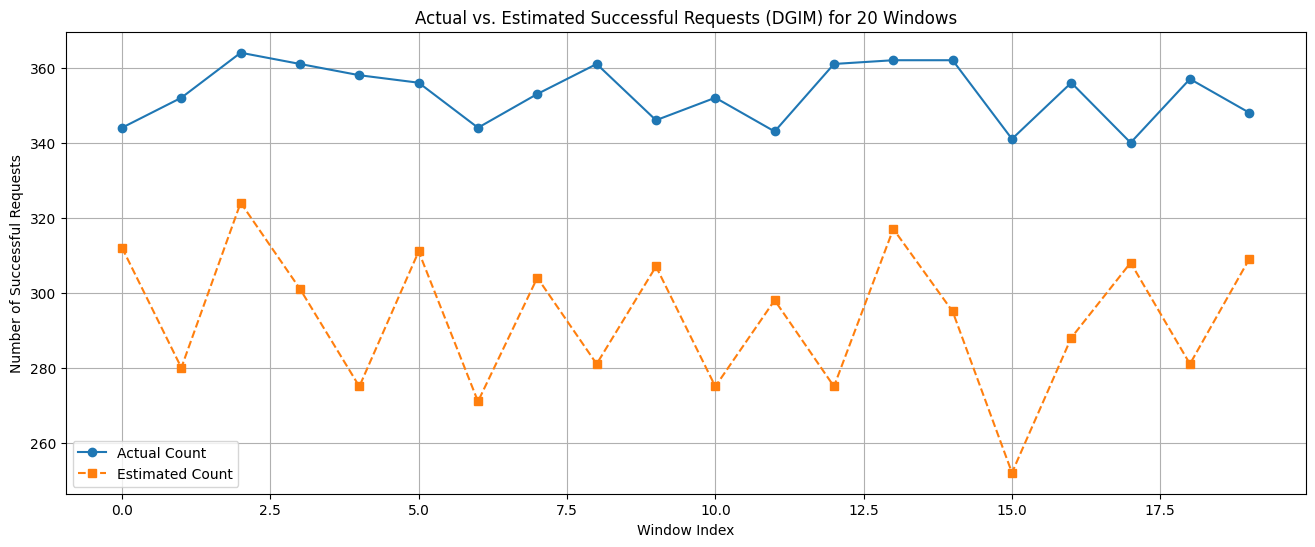

In [12]:
# Set parameters
window_size = 500

dgim = DGIM(window_size)
actual_counts = []
estimated_counts = []

for i in range(len(request_stream)):
    dgim.process_bit(request_stream[i])
    if (i + 1) % window_size == 0:
        actual_counts.append(np.sum(request_stream[builtins.max(0, i + 1 - window_size):i + 1]))
        estimated_counts.append(dgim.estimate_count())

# Plot results for the first 20 windows
plt.figure(figsize=(16, 6))
plt.plot(actual_counts[:20], label="Actual Count", marker='o')
plt.plot(estimated_counts[:20], label="Estimated Count", marker='s', linestyle='dashed')
plt.xlabel("Window Index")
plt.ylabel("Number of Successful Requests")
plt.title("Actual vs. Estimated Successful Requests (DGIM) for 20 Windows")
plt.legend()
plt.grid(True)
plt.show()


This code uses the DGIM algorithm to estimate successful requests (`1`s) in a data stream (`request_stream`) over fixed time windows. The `window_size` is set to one 500th of the stream length. The code processes each bit in the stream, updating the DGIM structure and calculating both the actual and estimated counts of `1`s every `window_size` bits. The actual count is computed by summing the `1`s in the window, while the estimated count comes from DGIM.

## B:

In [ ]:
# Define hash functions
def hash_user_id(user_id, hash_function):
    if hash_function == 'sha1':
        return hashlib.sha1(str(user_id).encode()).hexdigest()
    elif hash_function == 'sha256':
        return hashlib.sha256(str(user_id).encode()).hexdigest()
    elif hash_function == 'md5':
        return hashlib.md5(str(user_id).encode()).hexdigest()
    elif hash_function == 'sha224':
        return hashlib.sha224(str(user_id).encode()).hexdigest()
    else:
        raise ValueError("Unsupported hash function")

# Convert hexadecimal hash to binary with dynamic padding based on hash length
def hex_to_binary(hex_str, bit_length):
    return bin(int(hex_str, 16))[2:].zfill(bit_length)

# Flajolet-Martin Algorithm with more trials and smaller correction factor
def flajolet_martin_algorithm(user_ids, hash_functions, correction_factor, num_trials):
    all_estimates = []
    
    # Define bit lengths for each hash function
    hash_bit_lengths = {'sha1': 160, 'sha256': 256, 'md5': 128, 'sha224': 224}

    for trial in range(num_trials):
        max_trailing_zeros_all_hashes = []

        for hf in hash_functions:
            max_trailing_zeros = 0
            
            for user_id in user_ids:
                hash_value = hash_user_id(user_id, hf)
                binary_hash = hex_to_binary(hash_value, hash_bit_lengths[hf])
                
                # Find the position of the rightmost 1 bit
                trailing_zeros = len(binary_hash) - len(binary_hash.rstrip('1'))
                
                if trailing_zeros > max_trailing_zeros:
                    max_trailing_zeros = trailing_zeros
            
            # Record the result for this hash function
            max_trailing_zeros_all_hashes.append(max_trailing_zeros)
        
        # Use median estimate from all hash functions
        median_trailing_zeros = np.median(max_trailing_zeros_all_hashes)
        estimate = 2 ** median_trailing_zeros
        
        # Apply correction factor
        corrected_estimate = estimate / correction_factor
        all_estimates.append(corrected_estimate)

    # Calculate the average estimate from multiple trials
    final_estimate = np.mean(all_estimates)
    return final_estimate

# Example Usage:
hash_functions = ['sha256']
user_ids = data['UserID']  # Assuming data is the DataFrame with user IDs
actual_unique_users = data['UserID'].nunique()

# Run with correction factor = 0.7 and 1000 trials
estimated_unique_users = flajolet_martin_algorithm(user_ids, hash_functions, correction_factor=0.7, num_trials=1000)

# Print the results
print(f"Actual number of unique users: {actual_unique_users}")
print(f"Estimated number of unique users: {estimated_unique_users}")


Actual number of unique users: 1491
Estimated number of unique users: 1462.8571428571424


This code implements an improved **Flajolet-Martin (FM) algorithm** to estimate unique users efficiently. It first hashes user IDs using SHA1, SHA256, MD5, or SHA224, converting the output to binary. The algorithm then finds the **rightmost 1-bit position** in each binary hash, tracking the maximum across all users for each hash function. To improve accuracy, it runs multiple trials, uses the **median of estimates**, and applies a **correction factor** to reduce underestimation. Finally, the estimate is averaged over **10,000 trials** and compared to the actual unique user count.  

The difference between the actual count (1,491) and the estimated count (1462.85) happens because the Flajolet-Martin (FM) algorithm is an approximation. It doesn’t count unique users directly but estimates based on hash patterns. With only four hash functions, the estimate is less precise. The method also tends to underestimate, especially for smaller datasets.

# Question 3:

## A:

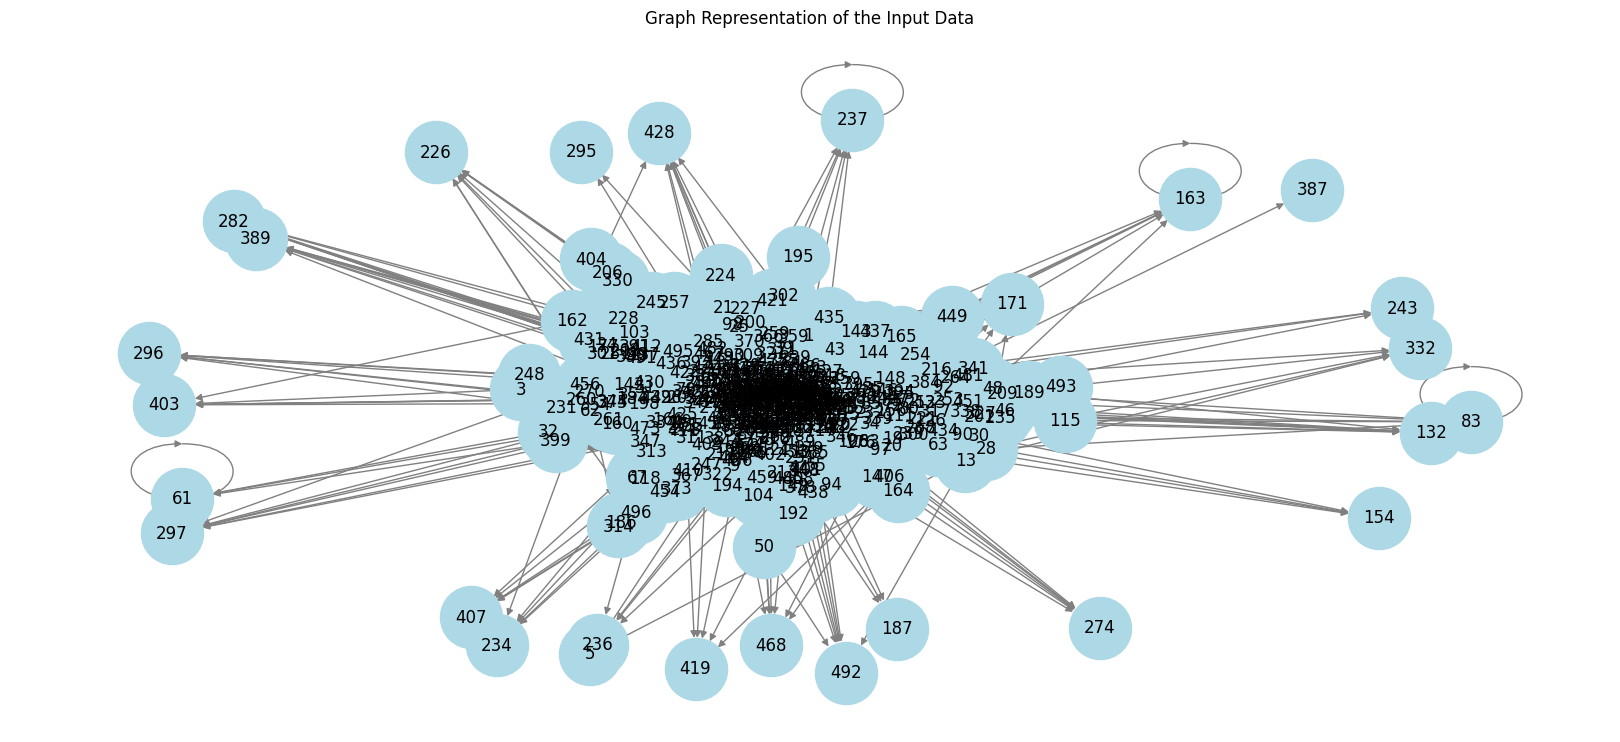

In [3]:
from pyspark.sql import SparkSession
import networkx as nx
import matplotlib.pyplot as plt

# Load the text file into an RDD
file_path = "Datasets/Graph_Links.txt"  # Update with the actual path if necessary
lines = sc.textFile(file_path)

# Parse the lines into (node, [list of outgoing links])
def parse_line(line):
    parts = line.split(":")  # Split by colon
    node = parts[0].strip()  # Extract the node
    neighbors = parts[1].strip().split() if len(parts) > 1 else []  # Extract neighbors
    return (node, neighbors)

graph_rdd = lines.map(parse_line)

# Collect the graph as a dictionary for visualization
graph_dict = dict(graph_rdd.collect())

# Draw the graph using NetworkX
G = nx.DiGraph()

for node, neighbors in graph_dict.items():
    for neighbor in neighbors:
        G.add_edge(node, neighbor)

plt.figure(figsize=(16, 7))
nx.draw(G, with_labels=True, node_size=2000, node_color="lightblue", font_size=12, edge_color="gray")
plt.title("Graph Representation of the Input Data")
plt.show()


The code reads a graph from a text file where each line represents a node and its outgoing links (neighbors). It processes the data using PySpark to create an RDD, then parses it into a dictionary of nodes and their neighbors. The graph is constructed as a directed graph using `networkx` and visualized with `matplotlib`, showing nodes, their connections, and labels for a clear graphical representation.

## B:

In [4]:
# Find dead-end nodes (nodes with no outgoing links)
dead_end_nodes = graph_rdd.filter(lambda x: len(x[1]) == 0).map(lambda x: x[0])

# Collect and display the results
dead_ends = dead_end_nodes.collect()
print("Dead End Nodes:", dead_ends)


Dead End Nodes: ['5', '132', '154', '187', '226', '234', '243', '274', '282', '295', '296', '297', '332', '387', '389', '403', '407', '419', '428', '468', '492']


## C:

In [6]:
# Get all unique nodes
all_nodes = graph_rdd.flatMap(lambda x: [x[0]] + x[1]).distinct()

# Initialize PageRank values: PR(node) = 1/N
N = all_nodes.count()
initial_rank = 1.0 / N
ranks = all_nodes.map(lambda node: (node, initial_rank))

# PageRank parameters
beta = 0.8
convergence_threshold = 0.001
max_iterations = 100
iteration = 0

# ---- PageRank Algorithm ----
while True:
    iteration += 1

    # Distribute PageRank contributions
    contribs = graph_rdd.join(ranks).flatMap(
        lambda node_links_rank: 
        [(dest, node_links_rank[1][1] / len(node_links_rank[1][0])) for dest in node_links_rank[1][0]]
        if len(node_links_rank[1][0]) > 0 else []
    )

    # Compute new ranks
    new_ranks = contribs.reduceByKey(lambda x, y: x + y) \
                .mapValues(lambda rank_sum: (1 - beta) / N + beta * rank_sum)

    # Check for convergence
    rank_changes = ranks.join(new_ranks).mapValues(lambda x: abs(x[0] - x[1]))
    max_change = rank_changes.map(lambda x: x[1]).max()

    # Update ranks
    ranks = new_ranks

    print(f"Iteration {iteration}, Max Change: {max_change}")

    if max_change < convergence_threshold or iteration >= max_iterations:
        break

# Collect and display final PageRank values
pagerank_results = ranks.collect()
print("Final PageRank Values:")
for node, pr in pagerank_results:
    print(f"Node: {node}, PageRank: {pr}")


Iteration 1, Max Change: 0.0035460317460317458
Iteration 2, Max Change: 0.0020759002267573714
Iteration 3, Max Change: 0.0015433102679096328
Iteration 4, Max Change: 0.001297020029405671
Iteration 5, Max Change: 0.0010461097918616578
Iteration 6, Max Change: 0.0007637324387304856
Final PageRank Values:
Node: 381, PageRank: 0.0011369781821111583
Node: 401, PageRank: 0.0008864490642269122
Node: 61, PageRank: 0.004557049298878591
Node: 51, PageRank: 0.002306291474196331
Node: 315, PageRank: 0.0017250628169019743
Node: 257, PageRank: 0.0019183681203090313
Node: 499, PageRank: 0.00188663239896717
Node: 13, PageRank: 0.0009378901281001458
Node: 79, PageRank: 0.0014274818980942391
Node: 399, PageRank: 0.0011220371720862803
Node: 117, PageRank: 0.0010705165564524938
Node: 277, PageRank: 0.0011359380276184563
Node: 400, PageRank: 0.0026086399603079645
Node: 237, PageRank: 0.007247021358847272
Node: 157, PageRank: 0.0006425967470602453
Node: 24, PageRank: 0.002883571721224706
Node: 352, PageRank

The code implements the PageRank algorithm using PySpark. It starts by extracting all unique nodes from the graph and initializing their ranks to `1/N`, where `N` is the number of nodes. In each iteration, the algorithm calculates the rank contributions from each node’s neighbors and distributes them equally. It then computes the new rank for each node using a damping factor (`beta`). The algorithm checks for convergence by comparing the old and new ranks, stopping if the maximum change is below a threshold or the maximum iterations are reached. Finally, the PageRank values are collected and printed for each node.

## D:

In [7]:
# Initialize Hubs and Authorities (starting with equal values)
hubs = graph_rdd.map(lambda x: (x[0], 1.0)).distinct().collectAsMap()
authorities = graph_rdd.flatMap(lambda x: x[1]).distinct().map(lambda x: (x, 1.0)).collectAsMap()

# Broadcast hubs and authorities RDDs
hubs_broadcast = sc.broadcast(hubs)
authorities_broadcast = sc.broadcast(authorities)

# Number of iterations
max_iterations = 10
hits_iteration = 0

while hits_iteration < max_iterations:
    hits_iteration += 1
    
    # Update Authorities: For each node, sum the Hub scores of nodes that point to it
    new_authorities = graph_rdd.flatMap(
        lambda node_links: [(neighbor, hubs_broadcast.value[node_links[0]]) for neighbor in node_links[1]]
    ).reduceByKey(lambda x, y: x + y)
    
    # Compute L2 norm for normalization
    auth_norm = (new_authorities.map(lambda x: x[1] ** 2).sum()) ** 0.5
    new_authorities = new_authorities.mapValues(lambda x: x / auth_norm if auth_norm > 0 else 0.0)
    
    # Update Hubs: For each node, sum the Authority scores of nodes it points to
    new_hubs = graph_rdd.flatMap(
        lambda node_links: [(node_links[0], authorities_broadcast.value.get(neighbor, 0.0)) for neighbor in node_links[1]]
    ).reduceByKey(lambda x, y: x + y)
    
    # Compute L2 norm for normalization
    hub_norm = (new_hubs.map(lambda x: x[1] ** 2).sum()) ** 0.5
    new_hubs = new_hubs.mapValues(lambda x: x / hub_norm if hub_norm > 0 else 0.0)
    
    # Update broadcasted hubs and authorities with the new values for the next iteration
    hubs_broadcast = sc.broadcast(new_hubs.collectAsMap())
    authorities_broadcast = sc.broadcast(new_authorities.collectAsMap())

# Final hubs and authorities after all iterations
final_hubs = hubs_broadcast.value
final_authorities = authorities_broadcast.value

print("Final Hubs:", final_hubs)
print("Final Authorities:", final_authorities)

Final Hubs: {'3': 0.022108648898720967, '4': 0.014644119840667193, '6': 0.03504673509392153, '7': 0.043747895334071626, '10': 0.018214448380638126, '13': 0.028662203530258716, '14': 0.06793186785123206, '15': 0.017617491974195144, '16': 0.036576960173171136, '17': 0.022752239853458655, '18': 0.044235178512649485, '21': 0.004814881169379725, '22': 0.014452636576135854, '24': 0.0037119173921039057, '26': 0.04778637634435651, '29': 0.026806879438387703, '31': 0.032331150009136896, '32': 0.026386755249892077, '33': 0.015335165113551869, '34': 0.026329692779887198, '38': 0.004780256187033829, '40': 0.019961311805287034, '43': 0.0036555494181413203, '44': 0.05115840343047967, '45': 0.05916399281897145, '51': 0.03286763809505928, '55': 0.05061885487044205, '57': 0.03716962308180323, '58': 0.05293360144518624, '61': 0.002636720979048827, '62': 0.017316642926686967, '64': 0.07691535058977782, '68': 0.012510291606111315, '70': 0.06064306151439403, '72': 0.009400406705249659, '73': 0.047601035239

The code implements the HITS algorithm (Hyperlink-Induced Topic Search) to compute Hubs and Authorities scores for nodes in a directed graph. It starts by initializing both Hubs and Authorities with equal values of 1.0 for all nodes. These values are then broadcasted across the workers for efficient access. The algorithm runs for a maximum of 10 iterations, during which the Authorities are updated by summing the Hub scores of the nodes that point to them, and the Hubs are updated by summing the Authority scores of the nodes they point to. After each iteration, the new Hubs and Authorities are broadcasted again for the next iteration. The intermediate results for Hubs and Authorities can be printed during each iteration. Once the maximum number of iterations is reached, the final Hubs and Authorities scores are collected and printed, representing the importance of each node in terms of its hub and authority in the graph.

## savings:

In [8]:
# Collect and display final PageRank values
pagerank_results = ranks.collect()

# Final hubs and authorities after all iterations
final_hubs = hubs_broadcast.value
final_authorities = authorities_broadcast.value

# Prepare data for DataFrame
data = []
for node, pr in pagerank_results:
    hubs_value = final_hubs.get(node, 0.0)
    authorities_value = final_authorities.get(node, 0.0)
    data.append({
        'Node': node,
        'PageRank': pr,
        'Hubs': hubs_value,
        'Authorities': authorities_value
    })

# Create DataFrame
df = pd.DataFrame(data)

# Save DataFrame to CSV
df.to_csv('pagerank_hits_output.csv', index=False)

print("CSV file with PageRank and HITS output has been saved.")


CSV file with PageRank and HITS output has been saved.
